# Statistical Arbitrage: Pairs Trading Strategy - Draft 1

## Overview

The project is inspired by tutorial by Quantopia, lecture by Eric Chan, and project by Pham the Anh.

### Key Components



1. Data Collection
2. Pairs Trading Strategy Development
3. Mathematical Proofs on Pairs Trading Setup
4. Backtesting
5. Optimization
6. Performance Analysis

## 1. Download Data

In [21]:
import yfinance as yf
import os
from datetime import datetime

Note that this draft version uses yahoo finacne data, which contains survivorship bias and look-ahead bias.

In [22]:
ticker_list = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'PYPL', 'ADBE', 'NFLX']

start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Create a directory to store the data
folder_name = 'stock_data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

def get_data(ticker):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        file_name = os.path.join(folder_name, f'{ticker}.csv')
        data.to_csv(file_name)
        print(f'File saved: {file_name}')
    except Exception as e:
        print(f'Error downloading {ticker}: {e}')

for ticker in ticker_list:
    get_data(ticker)

print('Done!')
    


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


File saved: stock_data\AAPL.csv
File saved: stock_data\MSFT.csv


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


File saved: stock_data\GOOGL.csv
File saved: stock_data\AMZN.csv


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


File saved: stock_data\META.csv
File saved: stock_data\TSLA.csv


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


File saved: stock_data\NVDA.csv
File saved: stock_data\PYPL.csv


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

File saved: stock_data\ADBE.csv
File saved: stock_data\NFLX.csv
Done!


## 2. Pair Trading Strategy

In [23]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.stattools import adfuller, coint
from itertools import combinations

In [24]:
import os
import pandas as pd
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import adfuller, coint

def load_stock_data(ticker, data_folder='stock_data'):
    file_name = os.path.join(data_folder, f'{ticker}.csv')
    print(f"Loading data for {ticker} from {file_name}")
    data = pd.read_csv(file_name, index_col='Date', parse_dates=True)
    return data

def calculate_log_spread_and_zscore(stock1, stock2):
    log_spread = np.log(stock1['Close']) - np.log(stock2['Close'])
    zscore = (log_spread - log_spread.mean()) / log_spread.std()
    return log_spread, zscore

def pair_analysis(stock1, stock2, name1, name2):
    log_spread, zscore = calculate_log_spread_and_zscore(stock1, stock2)
    adf_result = adfuller(log_spread.dropna())
    score, p_value, _ = coint(stock1['Close'], stock2['Close'])
    correlation = stock1['Close'].corr(stock2['Close'])
    
    return {
        'pair': (name1, name2),
        'adf_p_value': adf_result[1],
        'correlation': correlation,
        'cointegration_p_value': p_value,
        'zscore': zscore,
        'log_spread': log_spread
    }

def analyze_pairs(ticker_list, data_folder='stock_data'):
    results = []
    for ticker1, ticker2 in combinations(ticker_list, 2):
        try:
            stock1 = load_stock_data(ticker1, data_folder)
            stock2 = load_stock_data(ticker2, data_folder)
            common_dates = stock1.index.intersection(stock2.index)
            stock1 = stock1.loc[common_dates]
            stock2 = stock2.loc[common_dates]
            result = pair_analysis(stock1, stock2, ticker1, ticker2)
            results.append({
                'pair': f'{ticker1}-{ticker2}',
                'cointegration_pvalue': result['cointegration_p_value'],
                'correlation': result['correlation'],
                'adf_pvalue': result['adf_p_value'],
                'mean_zscore': result['zscore'].mean(),
                'std_zscore': result['zscore'].std()
            })
        except Exception as e:
            print(f'Error analyzing pairs: {ticker1}--{ticker2}: {str(e)}')
    print("Pair analysis results:")
    print(pd.DataFrame(results))
    return pd.DataFrame(results)

def filter_suitable_pairs(df_results, cointegration_threshold=0.50, adf_threshold=0.50):
    suitable_pairs = df_results[
        (df_results['cointegration_pvalue'] < cointegration_threshold) &
        (df_results['adf_pvalue'] < adf_threshold)
    ]
    print("Suitable pairs after filtering:")
    print(suitable_pairs)
    return suitable_pairs.sort_values('correlation', ascending=False)

def find_best_pair(tickers, cointegration_threshold=0.50, adf_threshold=0.50, data_folder='stock_data'):
    all_pairs = analyze_pairs(tickers, data_folder)
    suitable_pairs = filter_suitable_pairs(all_pairs, cointegration_threshold, adf_threshold)
    
    if suitable_pairs.empty:
        print("No suitable pairs found.")
        return None, pd.DataFrame()  # Return None and an empty DataFrame instead of a string
    
    best_pair = suitable_pairs.iloc[0]
    stock1, stock2 = best_pair['pair'].split('-')
    stock1_data = load_stock_data(stock1, data_folder)
    stock2_data = load_stock_data(stock2, data_folder)
    common_dates = stock1_data.index.intersection(stock2_data.index)
    stock1_data = stock1_data.loc[common_dates]
    stock2_data = stock2_data.loc[common_dates]
    log_spread, z_score = calculate_log_spread_and_zscore(stock1_data, stock2_data)
    
    result = {
        'stock1': stock1,
        'stock2': stock2,
        'correlation': best_pair['correlation'],
        'cointegration_pvalue': best_pair['cointegration_pvalue'],
        'adf_pvalue': best_pair['adf_pvalue'],
        'mean_zscore': best_pair['mean_zscore'],
        'std_zscore': best_pair['std_zscore'],
        'log_spread': log_spread,
        'z_score': z_score
    }
    print("Best pair found:")
    print(result)
    return result, suitable_pairs

# Example usage
tickers = ['AAPL', 'MSFT', 'GOOGL']
result, suitable_pairs = find_best_pair(tickers)
print(result)
print(suitable_pairs)


Loading data for AAPL from stock_data\AAPL.csv
Loading data for MSFT from stock_data\MSFT.csv
Loading data for AAPL from stock_data\AAPL.csv
Loading data for GOOGL from stock_data\GOOGL.csv
Loading data for MSFT from stock_data\MSFT.csv
Loading data for GOOGL from stock_data\GOOGL.csv
Pair analysis results:
         pair  cointegration_pvalue  ...   mean_zscore  std_zscore
0   AAPL-MSFT              0.433767  ... -3.992514e-16         1.0
1  AAPL-GOOGL              0.380314  ...  9.981285e-17         1.0
2  MSFT-GOOGL              0.312973  ... -5.988771e-16         1.0

[3 rows x 6 columns]
Suitable pairs after filtering:
         pair  cointegration_pvalue  ...   mean_zscore  std_zscore
0   AAPL-MSFT              0.433767  ... -3.992514e-16         1.0
1  AAPL-GOOGL              0.380314  ...  9.981285e-17         1.0
2  MSFT-GOOGL              0.312973  ... -5.988771e-16         1.0

[3 rows x 6 columns]
Loading data for MSFT from stock_data\MSFT.csv
Loading data for GOOGL from stoc

**Calculate Kappa & Half-life**


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


def calculate_spread(stock1, stock2):
    return np.log(stock1['Close']) - np.log(stock2['Close'])

def calculate_half_life(spread):
    # Calculate the spread lagged by one period
    spread_lag = spread.shift(1) # shift the spread by one period
    spread_lag.iloc[0] = spread_lag.iloc[1] # set the first value to the second value
    spread_ret = spread - spread_lag # calculate the spread return
    spread_ret.iloc[0] = spread_ret.iloc[1] # set the first value to the second value
    spread_lag2 = sm.add_constant(spread_lag) # add a constant to the lagged spread
    model = sm.OLS(spread_ret, spread_lag2) # create a linear regression model
    res = model.fit() # fit the model
    halflife = int(round(-np.log(2) / res.params[1], 0)) # calculate the halflife
    return halflife

In [35]:
def calculate_kappa_half_life(spread):
    # Calculate Kappa
    spread_lag = spread.shift(1)
    delta_spread = spread - spread_lag
    reg = np.polyfit(spread_lag.dropna(), delta_spread.dropna(), deg=1)
    kappa = -reg[0]
    
    # Calculate Half-Life
    half_life = calculate_half_life(spread)
    
    return kappa, half_life

In [36]:
def calculate_kappa_and_half_life(stock1_data, stock2_data, plot=True):
    # Ensure both stocks have the same date range
    common_dates = stock1_data.index.intersection(stock2_data.index)
    stock1_data = stock1_data.loc[common_dates]
    stock2_data = stock2_data.loc[common_dates]
    
    # Calculate spread
    spread = calculate_spread(stock1_data, stock2_data)
    
    # Calculate Kappa and Half-Life
    kappa, half_life = calculate_kappa_half_life(spread)
    
    if plot:
        # Plot the spread
        plt.figure(figsize=(12, 6))
        plt.plot(spread)
        plt.title(f'Price Spread')
        plt.xlabel('Date')
        plt.ylabel('Spread')
        plt.show()
    
    return kappa, half_life

In [37]:
import backtrader as bt
import numpy as np
from collections import deque

class PairTradingStrategy(bt.Strategy):
    params = (
        ('lookback', 20),
        ('entry_threshold', 1.5),  # Entry threshold in terms of standard deviations
        ('stoploss_factor', 2.0),  # Stop-loss threshold in terms of standard deviations
        ('holding_time_factor', 1.5),  # Factor to determine max holding time based on half-life
        ('half_life', 14),  # Estimated half-life of mean reversion in days
        ('stock1', None),
        ('stock2', None),
    )

    def __init__(self):
        # Get the data for the two stocks
        self.stock1 = self.getdatabyname(self.params.stock1)
        self.stock2 = self.getdatabyname(self.params.stock2)

        # Initialize spread and mean/std
        self.spread = []
        self.mean = None
        self.std = None
        self.entry_price = None # Entry price for the current position
        self.entry_date = None # Entry date for the current position

        # Calculate max holding time
        self.max_holding_time = int(self.params.holding_time_factor * self.params.half_life)

        # Custom metrics tracking
        self.trades = []
        self.equity_curve = [self.broker.getvalue()]
        self.returns = deque(maxlen=252)  # For annual Sharpe ratio
        self.max_drawdown = 0
        self.peak = self.broker.getvalue()

    def next(self):
        # Calculate the spread
        spread = np.log(self.stock1.close[0]) - np.log(self.stock2.close[0])
        self.spread.append(spread)

        # Wait until we have enough data
        if len(self.spread) <= self.params.lookback:
            return

        # Calculate mean and standard deviation
        self.mean = np.mean(self.spread[-self.params.lookback:])
        self.std = np.std(self.spread[-self.params.lookback:])

        # Calculate trading thresholds
        buy_threshold = self.mean - self.params.entry_threshold * self.std
        sell_threshold = self.mean + self.params.entry_threshold * self.std

        # Trading logic
        # No existing position
        if not self.position: 
            if spread < buy_threshold:
                self.buy(data=self.stock1)
                self.sell(data=self.stock2)
                self.entry_price = spread
                self.entry_date = len(self)
                self.log_trade('ENTRY LONG')
            elif spread > sell_threshold:
                self.sell(data=self.stock1)
                self.buy(data=self.stock2)
                self.entry_price = spread
                self.entry_date = len(self)
                self.log_trade('ENTRY SHORT')
        # Existing position
        else: 
            # Check for exit conditions
            days_since_entry = len(self) - self.entry_date

            # Trong phần exit logic
            if (self.position.size > 0 and spread >= self.mean) or \
            (self.position.size < 0 and spread <= self.mean):
                self.close(data=self.stock1)
                self.close(data=self.stock2)
                self.log_trade('EXIT', days_since_entry, reason="Spread Reversion")
            elif days_since_entry >= self.max_holding_time:
                self.close(data=self.stock1)
                self.close(data=self.stock2)
                self.log_trade('EXIT', days_since_entry, reason="Max Holding Time")
                return

            # Check for stop-loss
            stop_loss_threshold = self.params.stoploss_factor * self.std
            if abs(spread - self.entry_price) > stop_loss_threshold:
                self.close(data=self.stock1)
                self.close(data=self.stock2)
                self.log_trade('STOP-LOSS', days_since_entry, reason="Stop-Loss Hit")

        # Update metrics
        current_value = self.broker.getvalue()
        self.equity_curve.append(current_value)
        
        # Calculate return
        if len(self.equity_curve) > 1:
            daily_return = (current_value - self.equity_curve[-2]) / self.equity_curve[-2]
            self.returns.append(daily_return)
        
        # Update max drawdown
        if current_value > self.peak:
            self.peak = current_value
        dd = (self.peak - current_value) / self.peak
        if dd > self.max_drawdown:
            self.max_drawdown = dd

    def log_trade(self, action, days_held=None, reason=None):
        if action.startswith('ENTRY'):
            self.entry_date = len(self)
            self.entry_price1 = self.stock1.close[0]
            self.entry_price2 = self.stock2.close[0]
        elif action in ['EXIT', 'STOP-LOSS']:
            exit_price1 = self.stock1.close[0]
            exit_price2 = self.stock2.close[0]
            pnl = self.broker.getvalue() - self.equity_curve[-1]
            pnl_pct = (pnl / self.equity_curve[-1]) * 100
            self.trades.append({
                'entry_date': self.data.datetime.date(-days_held) if days_held is not None else None,
                'exit_date': self.data.datetime.date(0),
                'days_held': days_held,
                'pnl': pnl,
                'pnl_pct': pnl_pct,
                'entry_price1': self.entry_price1,
                'entry_price2': self.entry_price2,
                'exit_price1': exit_price1,
                'exit_price2': exit_price2,
                'exit_type': action,
                'exit_reason': reason
            })

    def stop(self):
        # Calculate final metrics
        self.total_trades = len(self.trades)
        self.winning_trades = sum(1 for trade in self.trades if trade['pnl'] > 0)
        self.losing_trades = sum(1 for trade in self.trades if trade['pnl'] <= 0)
        self.win_rate = self.winning_trades / self.total_trades if self.total_trades > 0 else 0

        self.total_return = (self.equity_curve[-1] - self.equity_curve[0]) / self.equity_curve[0]
        self.mean_return = np.mean(self.returns) if self.returns else 0
        self.std_return = np.std(self.returns) if self.returns else 0
        self.sharpe_ratio = np.sqrt(252) * self.mean_return / self.std_return if self.std_return != 0 else 0

        # Store all metrics in a dictionary for easy access
        self.metrics = {
            'Initial Capital': self.equity_curve[0],
            'Final Portfolio Value': self.equity_curve[-1],
            'Total Return (%)': self.total_return * 100,
            'Sharpe Ratio': self.sharpe_ratio,
            'Max Drawdown (%)': self.max_drawdown * 100,
            'Total Trades': self.total_trades,
            'Winning Trades': self.winning_trades,
            'Losing Trades': self.losing_trades,
            'Win Rate (%)': self.win_rate * 100,
            'Mean Daily Return (%)': self.mean_return * 100,
            'Std Dev of Daily Return (%)': self.std_return * 100
        }

In [38]:
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

class BacktestEngine:
    def __init__(self, strategy_class, df1, df2, initial_capital=100000, commission=0.001):
        self.cerebro = bt.Cerebro()
        self.strategy_class = strategy_class
        self.df1 = df1
        self.df2 = df2
        self.initial_capital = initial_capital
        self.commission = commission
        self.results = None

    def add_data(self):
        data1 = bt.feeds.PandasData(dataname=self.df1, name="stock1")
        data2 = bt.feeds.PandasData(dataname=self.df2, name="stock2")
        self.cerebro.adddata(data1)
        self.cerebro.adddata(data2)

    def set_strategy(self, **kwargs):
        self.cerebro.addstrategy(self.strategy_class, **kwargs)

    def set_broker(self, initial_capital=None, commission=None):
        if initial_capital is None:
            initial_capital = self.initial_capital
        if commission is None:
            commission = self.commission

    def run(self):
        self.add_data()
        self.set_broker()
        self.results = self.cerebro.run()

    def get_metrics(self):
        if not self.results:
            return {"Error": "No backtest results available. Please run the backtest first."}

        strat = self.results[0]
        
        if not hasattr(strat, 'metrics'):
            return {"Error": "No metrics found in the strategy. Make sure to implement custom metrics in your strategy."}
        
        return strat.metrics

    def print_metrics(self):
        metrics = self.get_metrics()
        if isinstance(metrics, dict) and "Error" in metrics:
            print(metrics["Error"])
            return

        table_data = [["Metric", "Value"]]
        for key, value in metrics.items():
            if isinstance(value, float):
                table_data.append([key, f"{value:.2f}"])
            else:
                table_data.append([key, value])

        print("\nBacktest Results:")
        print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

    def print_trade_table(self, num_trades=None):
        if not self.results:
            print("No results available. Make sure to run the backtest first.")
            return
        
        strat = self.results[0]
        if not hasattr(strat, 'trades'):
            print("No trade information found in the strategy. Make sure to log trades in your strategy.")
            return

        trades = strat.trades
        if num_trades is not None:
            trades = trades[:num_trades]
        
        trade_data = []
        for trade in trades:
            trade_data.append([
                trade.get('entry_date', 'N/A'),
                trade.get('exit_date', 'N/A'),
                trade.get('days_held', 'N/A'),
                f"{trade.get('pnl', 'N/A'):.2f}",
                f"{trade.get('pnl_pct', 'N/A'):.2f}%",
                f"{trade.get('entry_price1', 'N/A'):.2f}",
                f"{trade.get('entry_price2', 'N/A'):.2f}",
                f"{trade.get('exit_price1', 'N/A'):.2f}",
                f"{trade.get('exit_price2', 'N/A'):.2f}",
                trade.get('exit_type', 'N/A'), 
                trade.get('exit_reason', 'N/A')
            ])
        
        headers = ["Entry Date", "Exit Date", "Days Held", "PnL", "PnL %", 
                   "Entry Price 1", "Entry Price 2", "Exit Price 1", "Exit Price 2", "Exit Type", "Exit Reason"]
        
        print("\nTrade History:")
        print(tabulate(trade_data, headers=headers, tablefmt="grid"))

    def plot_equity_curve(self):
        if not self.results:
            print("No results available. Make sure to run the backtest first.")
            return
        
        strat = self.results[0]
        if not hasattr(strat, 'equity_curve'):
            print("No equity curve data found in the strategy.")
            return
        
        # Convert equity curve to pandas Series
        equity_curve = pd.Series(strat.equity_curve, index=self.df1.index[:len(strat.equity_curve)])
        
        # Calculate drawdown
        drawdown = (equity_curve.cummax() - equity_curve) / equity_curve.cummax()
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})
        fig.suptitle('Equity Curve and Drawdown', fontsize=16)
        
        # Plot equity curve
        ax1.plot(equity_curve.index, equity_curve.values, label='Equity Curve', color='blue')
        ax1.set_title('Equity Curve')
        ax1.set_ylabel('Portfolio Value')
        ax1.legend()
        ax1.grid(True)
        
        # Plot drawdown
        ax2.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red', label='Drawdown')
        ax2.set_title('Drawdown')
        ax2.set_ylabel('Drawdown')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid(True)
        
        # Format x-axis
        plt.gcf().autofmt_xdate()
        
        # Add strategy performance metrics as text
        metrics = self.get_metrics()
        metrics_text = (f"Total Return: {metrics['Total Return (%)']:.2f}%\n"
                        f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}\n"
                        f"Max Drawdown: {metrics['Max Drawdown (%)']:.2f}%\n"
                        f"Win Rate: {metrics['Win Rate (%)']:.2f}%")
        fig.text(0.02, 0.02, metrics_text, fontsize=10, va='bottom')
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Show plot
        plt.show()

    def plot_results(self):
        if not self.results:
            print("No results available. Make sure to run the backtest first.")
            return

        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        self.cerebro.plot(style='candlestick')
        plt.title('Backtest Results')
        
        plt.subplot(2, 1, 2)
        strat = self.results[0]
        if hasattr(strat, 'equity_curve'):
            plt.plot(strat.equity_curve)
            plt.title('Portfolio Value Over Time')
        else:
            print("No equity curve data found in the strategy.")
        
        plt.tight_layout()
        plt.show()

Backtest Pair Trading Strategy


Backtest Results:
+-----------------------------+----------+
| Metric                      |    Value |
+=============================+==========+
| Initial Capital             | 10000    |
+-----------------------------+----------+
| Final Portfolio Value       |  9957.84 |
+-----------------------------+----------+
| Total Return (%)            |    -0.42 |
+-----------------------------+----------+
| Sharpe Ratio                |     0.26 |
+-----------------------------+----------+
| Max Drawdown (%)            |     2.42 |
+-----------------------------+----------+
| Total Trades                |   100    |
+-----------------------------+----------+
| Winning Trades              |    65    |
+-----------------------------+----------+
| Losing Trades               |    35    |
+-----------------------------+----------+
| Win Rate (%)                |    65    |
+-----------------------------+----------+
| Mean Daily Return (%)       |     0    |
+-----------------------------+----

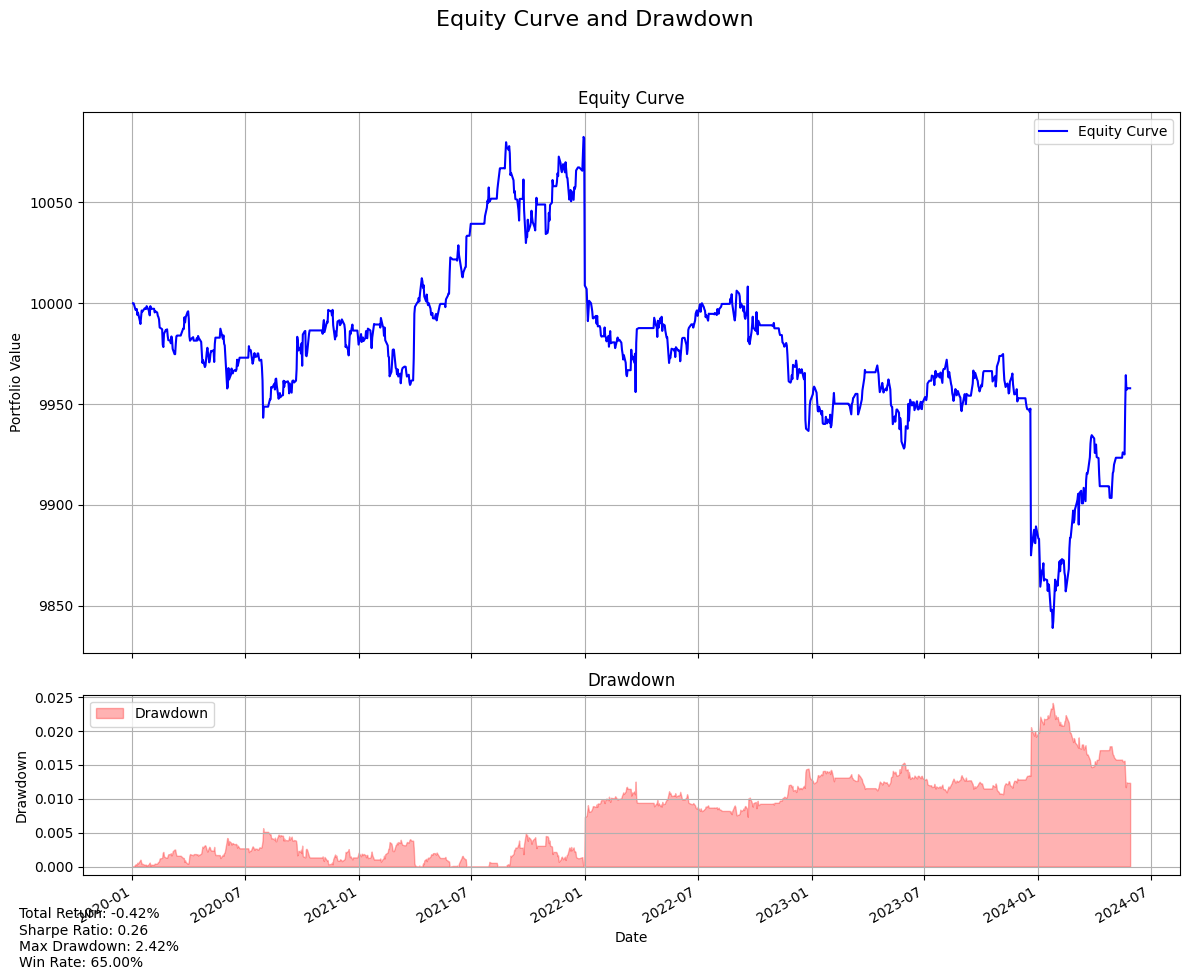

<IPython.core.display.Javascript object>

C:\Users\USER\AppData\Local\Temp\ipykernel_23300\3645758699.py:169: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


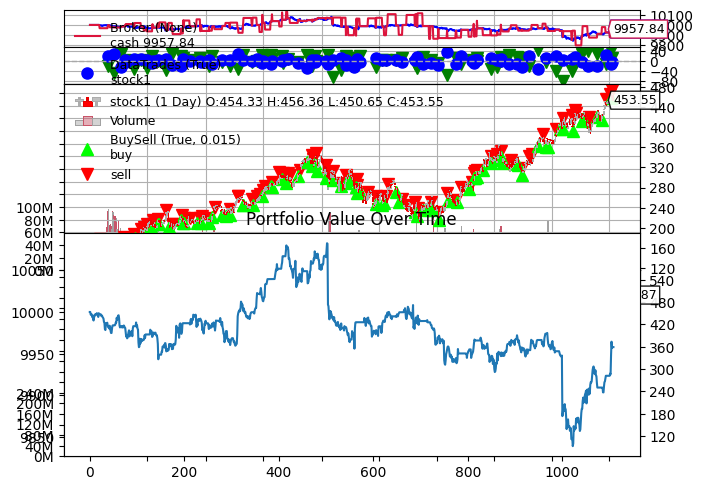

In [39]:
import pandas as pd
import numpy as np
%matplotlib inline

def main():
    # Define all parameters
    params = {
        # Data parameters
        'stock1': "MSFT",
        'stock2': "META",
        'start_date': '2020-01-01',
        'end_date': '2023-01-01',
        
        # Strategy parameters
        'lookback': 20,
        'entry_threshold': 1.5,
        'stoploss_factor': 2.0,
        'kappa': 0.06,
        'half_life': 12.25,
        
        # Backtest parameters
        'initial_capital': 100000,
        'commission': 0.001,  # 0.1% commission
    }
    
    # Load data
    df1 = pd.read_csv(f'stock_data/{params["stock1"]}.csv', index_col='Date', parse_dates=True)
    df2 = pd.read_csv(f'stock_data/{params["stock2"]}.csv', index_col='Date', parse_dates=True)
    
    # Ensure both stocks have the same date range
    common_dates = df1.index.intersection(df2.index)
    df1 = df1.loc[common_dates]
    df2 = df2.loc[common_dates]
    
    # Calculate Kappa and Half-Life if not provided
    if params['kappa'] is None or params['half_life'] is None:
        params['kappa'], params['half_life'] = calculate_kappa_and_half_life(df1, df2)
        print(f"Calculated Kappa: {params['kappa']:.2f}")
        print(f"Calculated Half-Life: {params['half_life']:.2f}")
    
    # Create BacktestEngine instance
    engine = BacktestEngine(
        strategy_class=PairTradingStrategy,
        df1=df1,
        df2=df2,
        initial_capital=params['initial_capital']
    )

    # Set strategy parameters
    engine.set_strategy(
        lookback=params['lookback'],
        entry_threshold=params['entry_threshold'],
        stoploss_factor=params['stoploss_factor'],
        # kappa=params['kappa'],
        half_life=params['half_life'],
        stock1="stock1",
        stock2="stock2"
    )

    # Set broker parameters
    engine.set_broker(commission=params['commission'], initial_capital=params['initial_capital'])

    # Run the backtest
    engine.run()

    # # print trade table
    # engine.print_trade_table()

    # Get and print metrics
    engine.print_metrics()

    # Plot the equity curve
    engine.plot_equity_curve()

    # Plot the results
    engine.plot_results()

if __name__ == "__main__":
    main()

## Bayesian Optimization

To find the best parameters

In [40]:
# %pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def objective(params, df1, df2, initial_capital=100000, commission=0.001):
    lookback, entry_threshold, stoploss_factor, holding_time_factor, half_life = params
    
    engine = BacktestEngine(
        strategy_class=PairTradingStrategy,
        df1=df1,
        df2=df2,
        initial_capital=initial_capital
    )
    
    engine.set_strategy(
        lookback=int(lookback),
        entry_threshold=entry_threshold,
        stoploss_factor=stoploss_factor,
        holding_time_factor=holding_time_factor,
        half_life=half_life,
        stock1="stock1",
        stock2="stock2"
    )
    
    engine.set_broker(commission=commission, initial_capital=initial_capital)
    engine.run()
    metrics = engine.get_metrics()
    
    # We want to maximize Sharpe Ratio, so we return its negative
    return -metrics.get('Sharpe Ratio', 0)

def bayesian_optimization(df1, df2, param_ranges, n_calls=50, initial_capital=100000, commission=0.001):
    space = [
        Integer(param_ranges['lookback'][0].min(), param_ranges['lookback'][0].max(), name='lookback'),
        Real(param_ranges['entry_threshold'][0].min(), param_ranges['entry_threshold'][0].max(), name='entry_threshold'),
        Real(param_ranges['stoploss_factor'][0].min(), param_ranges['stoploss_factor'][0].max(), name='stoploss_factor'),
        Real(param_ranges['holding_time_factor'][0].min(), param_ranges['holding_time_factor'][0].max(), name='holding_time_factor'),
    ]
    
    fixed_half_life = param_ranges['half_life'][0]
    
    @use_named_args(space)
    def objective_wrapper(**params):
        params_list = list(params.values()) + [fixed_half_life]
        return objective(params_list, df1, df2, initial_capital, commission)
    
    def callback(res):
        n = len(res.x_iters)
        print(f"Optimization progress: {n / n_calls * 100:.2f}%")
    
    result = gp_minimize(objective_wrapper, space, n_calls=n_calls, random_state=42, callback=callback)
    
    best_params = {
        'lookback': int(result.x[0]),
        'entry_threshold': result.x[1],
        'stoploss_factor': result.x[2],
        'holding_time_factor': result.x[3],
        'half_life': fixed_half_life
    }
    
    return best_params, -result.fun  # Return best parameters and best Sharpe Ratio

Run to find the best parameters

**************************************************
Finding the best pair for pair trading...
Loading data for AAPL from stock_data\AAPL.csv
Loading data for MSFT from stock_data\MSFT.csv
Loading data for AAPL from stock_data\AAPL.csv
Loading data for GOOGL from stock_data\GOOGL.csv
Loading data for AAPL from stock_data\AAPL.csv
Loading data for AMZN from stock_data\AMZN.csv
Loading data for AAPL from stock_data\AAPL.csv
Loading data for META from stock_data\META.csv
Loading data for AAPL from stock_data\AAPL.csv
Loading data for TSLA from stock_data\TSLA.csv
Loading data for AAPL from stock_data\AAPL.csv
Loading data for NVDA from stock_data\NVDA.csv
Loading data for AAPL from stock_data\AAPL.csv
Loading data for PYPL from stock_data\PYPL.csv
Loading data for AAPL from stock_data\AAPL.csv
Loading data for ADBE from stock_data\ADBE.csv
Loading data for AAPL from stock_data\AAPL.csv
Loading data for NFLX from stock_data\NFLX.csv
Loading data for MSFT from stock_data\MSFT.csv
Loading data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Pair analysis results:
          pair  cointegration_pvalue  ...   mean_zscore  std_zscore
0    AAPL-MSFT              0.433767  ... -3.992514e-16         1.0
1   AAPL-GOOGL              0.380314  ...  9.981285e-17         1.0
2    AAPL-AMZN              0.923965  ... -9.981285e-17         1.0
3    AAPL-META              0.721458  ... -9.981285e-17         1.0
4    AAPL-TSLA              0.952930  ... -1.621959e-16         1.0
5    AAPL-NVDA              0.413175  ...  1.996257e-16         1.0
6    AAPL-PYPL              0.675375  ... -9.981285e-17         1.0
7    AAPL-ADBE              0.957795  ...  9.981285e-17         1.0
8    AAPL-NFLX              0.900968  ...  2.495321e-16         1.0
9   MSFT-GOOGL              0.312973  ... -5.988771e-16         1.0
10   MSFT-AMZN              0.971125  ... -3.493450e-16         1.0
11   MSFT-META              0.637306  ...  0.000000e+00         1.0
12   MSFT-TSLA              0.990690  ...  0.000000e+00         1.0
13   MSFT-NVDA           


C:\Users\USER\AppData\Local\Temp\ipykernel_23300\4226515721.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  halflife = int(round(-np.log(2) / res.params[1], 0)) # calculate the halflife


Optimization progress: 2.00%
Optimization progress: 4.00%
Optimization progress: 6.00%
Optimization progress: 8.00%
Optimization progress: 10.00%
Optimization progress: 12.00%
Optimization progress: 14.00%
Optimization progress: 16.00%
Optimization progress: 18.00%
Optimization progress: 20.00%
Optimization progress: 22.00%
Optimization progress: 24.00%
Optimization progress: 26.00%
Optimization progress: 28.00%
Optimization progress: 30.00%
Optimization progress: 32.00%
Optimization progress: 34.00%
Optimization progress: 36.00%
Optimization progress: 38.00%
Optimization progress: 40.00%
Optimization progress: 42.00%
Optimization progress: 44.00%
Optimization progress: 46.00%
Optimization progress: 48.00%
Optimization progress: 50.00%
Optimization progress: 52.00%
Optimization progress: 54.00%
Optimization progress: 56.00%
Optimization progress: 58.00%
Optimization progress: 60.00%
Optimization progress: 62.00%
Optimization progress: 64.00%
Optimization progress: 66.00%
Optimization p

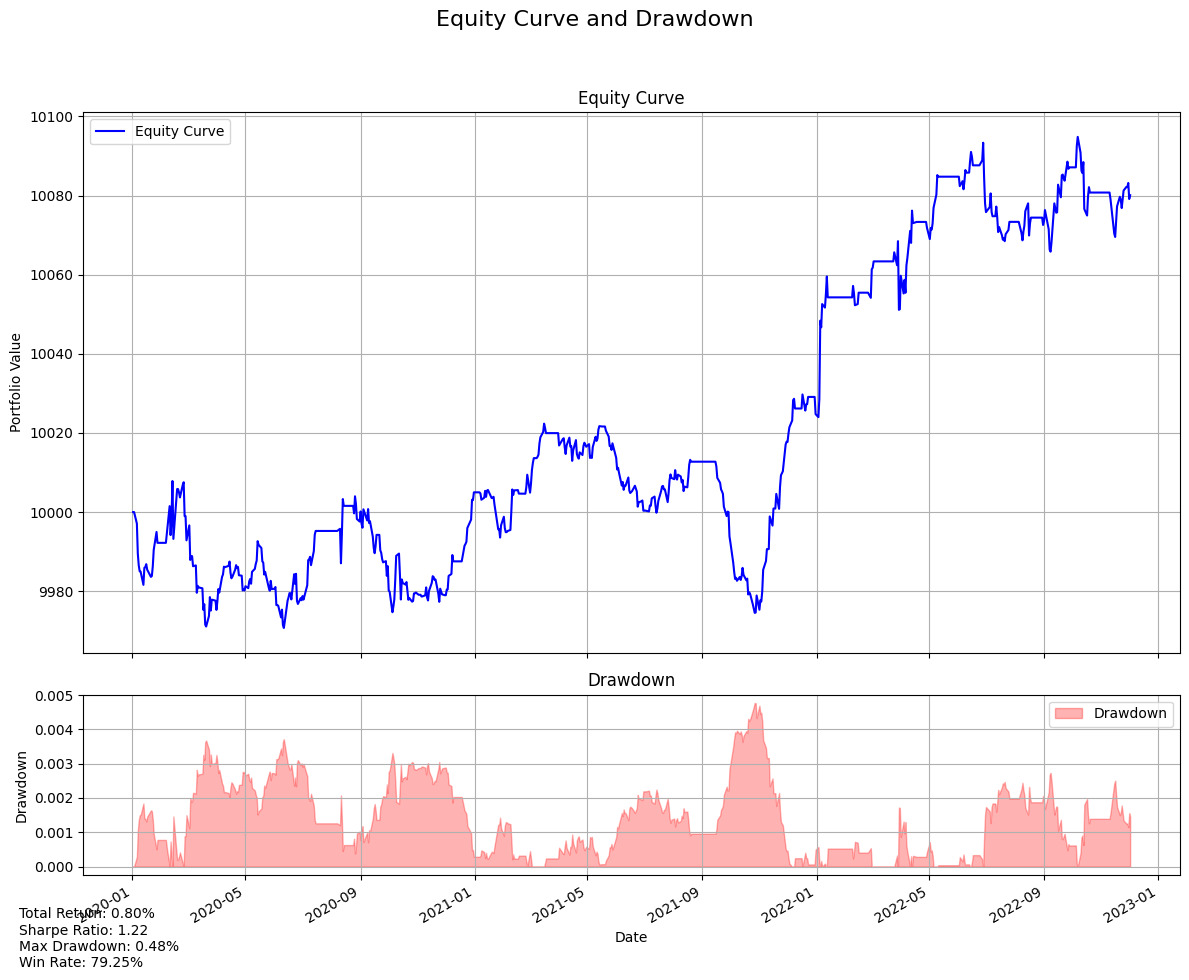

In [41]:
import yfinance as yf
import numpy as np
%matplotlib inline

def main():
    # Find the best pair for pair trading
    print("*" * 50)
    print("Finding the best pair for pair trading...")
    best_pair, suitable_pairs = find_best_pair(ticker_list)
    print("Completed pair analysis.")
    print("*" * 50)
    if best_pair is None:
        print("No suitable pairs found for pair trading.")
        return
    
    # get the best pair
    stock1 = best_pair['stock1']
    stock2 = best_pair['stock2']

    # Download stock data
    start_date = "2020-01-01"
    end_date = "2023-01-01"
    
    df1 = yf.download(stock1, start=start_date, end=end_date)
    df2 = yf.download(stock2, start=start_date, end=end_date)

    # Calculate kappa and half life
    kappa, half_life = calculate_kappa_and_half_life(df1, df2, plot=False)
    
    # Print CONFIG before optimization
    print("*" * 50)
    print("Stock Pair for Pair Trading:")
    print(f'Stock 1: {stock1}')
    print(f'Stock 2: {stock2}')
    print(f'Kappa: {kappa:.2f}')
    print(f'Half-Life: {half_life:.2f}')
    print("*" * 50)
    
    # Define parameter ranges for Bayesian optimization
    look_back_range = np.arange(5, 31, 1)
    entry_threshold_range = np.arange(1.5, 3.1, 0.1)
    stoploss_factor_range = np.arange(1.5, 3.1, 0.1)
    holding_time_factor_range = np.arange(1.0, 2.1, 0.1)
    param_ranges = {
        'lookback': [look_back_range],
        'entry_threshold': [entry_threshold_range],
        'stoploss_factor': [stoploss_factor_range],
        'holding_time_factor': [holding_time_factor_range],
        'half_life': [half_life]
    }
    
    # Run Bayesian optimization
    best_params, best_sharpe = bayesian_optimization(df1, df2, param_ranges, n_calls=50)
    
    print("*" * 50)
    print("\nBest parameters found:")
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print(f"Best Sharpe Ratio: {best_sharpe}")
    print("*" * 50)
    
    # Run final backtest with best parameters
    final_engine = BacktestEngine(
        strategy_class=PairTradingStrategy,
        df1=df1,
        df2=df2,
        initial_capital=100000
    )
    
    final_engine.set_strategy(**best_params, stock1="stock1", stock2="stock2")
    
    final_engine.set_broker(commission=0.001, initial_capital=100000)
    final_engine.run()
    
    print("*" * 50)
    print("\nFinal Backtest Results:")
    final_engine.print_metrics()
    final_engine.plot_equity_curve()

if __name__ == "__main__":
    main()